# 15. 심층 합성곱 신경망으로 이미지 분류

## 15.1 합성곱 신경망의 구성 요소

### 15.1.2 이산 합성곱 수행

In [1]:
import numpy as np
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p>0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

In [2]:
## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:', conv1d(x, w, p=2, s=1))

print('넘파이 결과:', np.convolve(x, w, mode='same'))

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


2D 이산 합성곱 수행

In [3]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0] + X_orig.shape[0],
             p[1]:p[1] + X_orig.shape[1]] = X_orig
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0]) / s[0]) +1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1]) / s[1]) +1, s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0],
                             j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

In [4]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d 구현:\n', conv2d(X, W, p=(1, 1), s=(1, 1)))

print('사이파이 결과:\n', scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
사이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### 15.1.3 서브샘플링

## 15.2 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 15.2.2 드롭아웃으로 신경망 규제

In [5]:
from tensorflow import keras
conv_layer = keras.layers.Conv2D(
    filters=16,
    kernel_size=(3,3),
    kernel_regularizer=keras.regularizers.l2(0.001))
fc_layer = keras.layers.Dense(
    units=16,
    kernel_regularizer=keras.regularizers.l2(0.001))

### 15.2.3 분류를 위한 손실 함수

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf

## 이진 크로스 엔트로피
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)
tf.print(
    'BCE (확률): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))

BCE (확률): 0.3711 (로짓): 0.3711


In [7]:
from distutils.version import LooseVersion as Version

####### 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

if Version(tf.__version__) >= '2.3.0':
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
else:
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[0, 0, 1], y_pred=logits)))

CCE (확률): 0.5996 (로짓): 0.5996


C:\Users\us\AppData\Local\Temp\ipykernel_6516\921979979.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Version(tf.__version__) >= '2.3.0':


In [8]:
## 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
tf.print(
    'Sparse CCE (확률): {:.4f}'.format(sp_cce_probas(y_true=[2], y_pred=probas)),
    '(로짓): {:.4f}'.format(sp_cce_logits(y_true=[2], y_pred=logits)) )

Sparse CCE (확률): 0.5996 (로짓): 0.5996


### 15.3 텐서플로를 사용하여 심층 합성곱 신경망 구현

### 15.3.2 데이터 적재와 전처리

In [9]:
import tensorflow_datasets as tfds
## 데이터 적재
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20
mnist_train = mnist_train_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                                  tf.cast(item['label'], tf.int32)))
mnist_test = mnist_test_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                                tf.cast(item['label'], tf.int32)))
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### 15.3.3 텐서플로 케라스 API를 사용하여 CNN 구현

케라스로 CNN 구성하기

In [11]:
# Sequential 클래스를 사용하고 합성곱과 풀링 층 추가
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', data_format='channels_last',
                                name='conv_1', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', name='conv_2',
                                 activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [12]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [13]:
# 밀집 완결층 추가
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [14]:
# 드롭아웃 추가
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [15]:
# 손실함수 SparseCategoricalCrossentropy
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
history = model.fit(mnist_train, epochs=NUM_EPOCHS,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 29s 35ms/step - loss: 0.1441 - accuracy: 0.9547 - val_loss: 0.0548 - val_accuracy: 0.9828
Epoch 2/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.0427 - val_accuracy: 0.9875
Epoch 3/20
782/782 [==============================] - 28s 35ms/step - loss: 0.0316 - accuracy: 0.9901 - val_loss: 0.0424 - val_accuracy: 0.9871
Epoch 4/20
782/782 [==============================] - 30s 38ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0385 - val_accuracy: 0.9900
Epoch 5/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0360 - val_accuracy: 0.9911
Epoch 6/20
782/782 [==============================] - 29s 37ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0410 - val_accuracy: 0.9900
Epoch 7/20
782/782 [==============================] - 30s 38ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0699 - val_accuracy:

In [17]:
conda install nb_conda_kernels

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


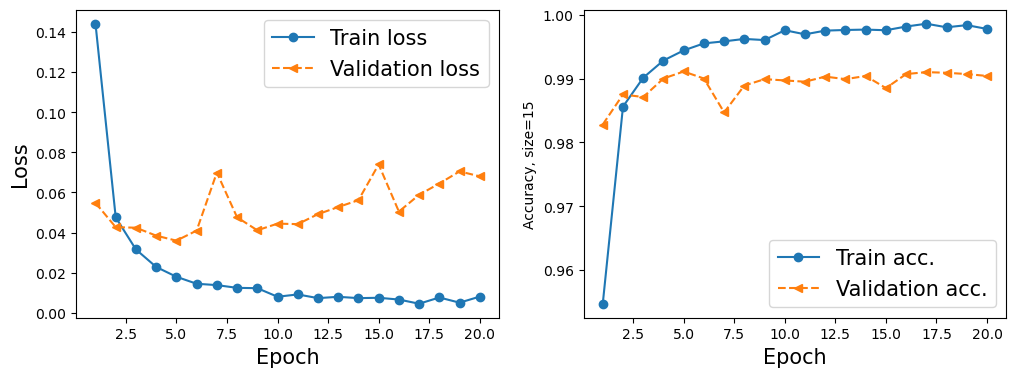

In [18]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy, size=15')
plt.show()

In [19]:
test_results = model.evaluate(mnist_test.batch(20))
print('테스트 정확도: {:.2f}\%'.format(test_results[1]*100))

500/500 [==============================] - 2s 4ms/step - loss: 0.0597 - accuracy: 0.9902
테스트 정확도: 99.02\%


In [20]:
batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [21]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


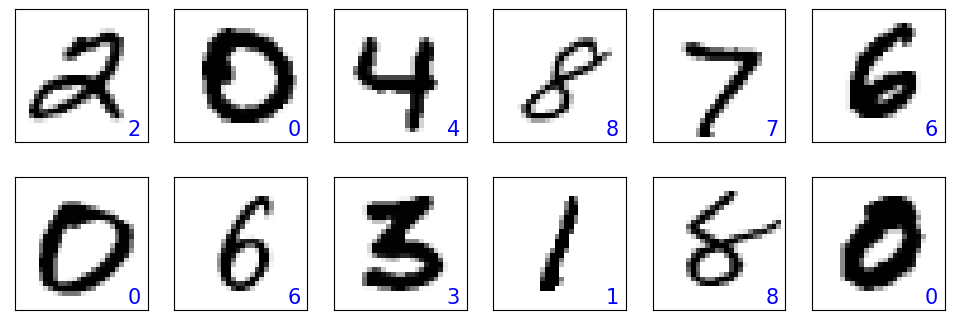

In [22]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('images/15_13.png', dpi=300)
plt.show()

## 15.4 합성곱 신경망을 사용하여 얼굴 이미지의 성별 분류

In [23]:
# tensorflow_datasets를 최신 버전으로 업데이트하세요.
!pip install --upgrade tensorflow_datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt

In [2]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('훈련 데이터셋:  {}'.format(count_items(celeba_train)))
print('검증 데이터셋:  {}'.format(count_items(celeba_valid)))
print('테스트 데이터셋: {}'.format(count_items(celeba_test)))

dict_keys(['train', 'validation', 'test'])
훈련 데이터셋:  162770
검증 데이터셋:  19867
테스트 데이터셋: 19962


In [3]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('훈련 데이터셋: {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))

훈련 데이터셋: 16000
검증 데이터셋: 1000


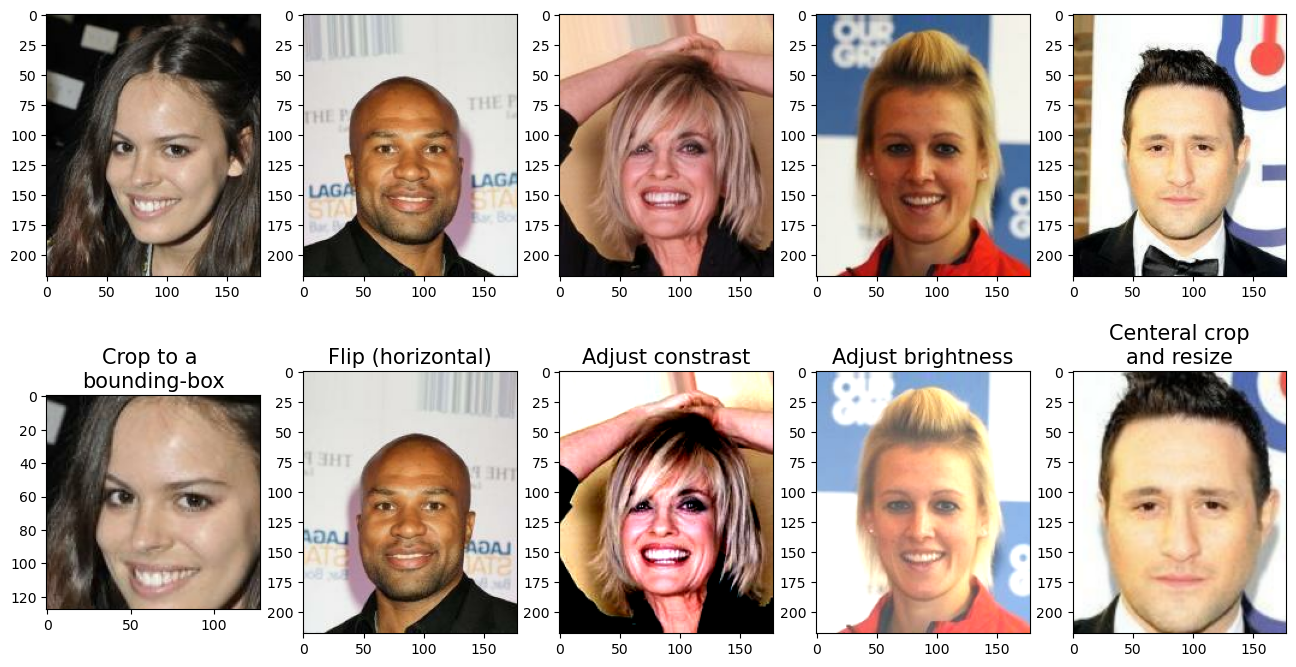

In [4]:
## 5개 샘플을 가져옵니다
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## 1열: 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## 2열: (수평으로) 뒤집기
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## 3열: 대비 조정
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열: 명도 조정
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## 5열: 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

# plt.savefig('images/15_14.png', dpi=300)
plt.show()

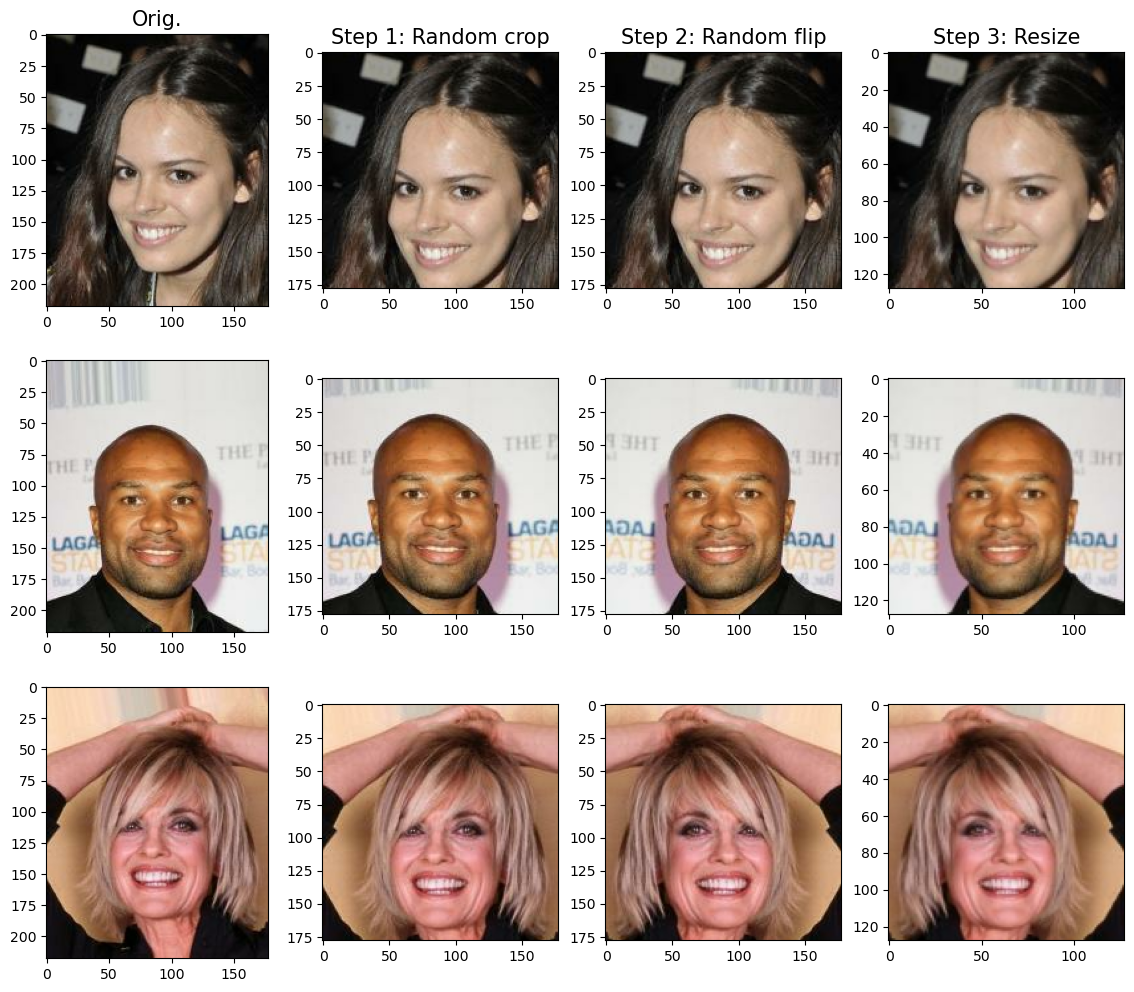

In [5]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

# plt.savefig('images/15_15.png', dpi=300)
plt.show()

In [6]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

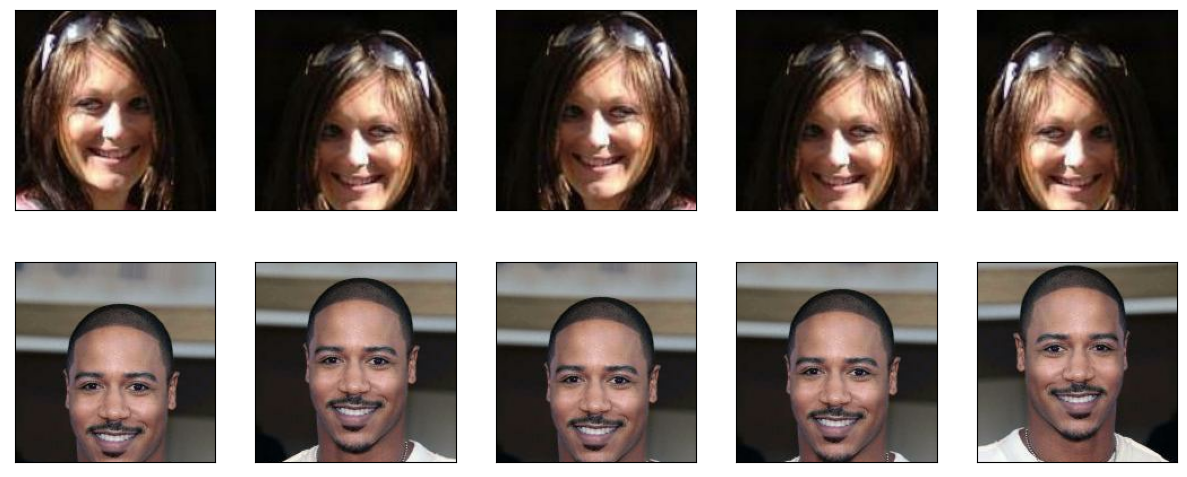

In [7]:
tf.random.set_seed(1)
ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))
fig = plt.figure(figsize=(15, 6))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
plt.show()

In [8]:
import numpy as np
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
ds_train = celeba_train.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)
ds_valid = celeba_valid.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
])

In [10]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [11]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [12]:
model.add(tf.keras.layers.Dense(1, activation=None))
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
500/500 [==============================] - 10s 11ms/step - loss: 0.6425 - accuracy: 0.6043 - val_loss: 0.5720 - val_accuracy: 0.6500
Epoch 2/20
500/500 [==============================] - 6s 11ms/step - loss: 0.5282 - accuracy: 0.7193 - val_loss: 0.4749 - val_accuracy: 0.7280
Epoch 3/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4705 - accuracy: 0.7602 - val_loss: 0.4067 - val_accuracy: 0.8180
Epoch 4/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4313 - accuracy: 0.7896 - val_loss: 0.3868 - val_accuracy: 0.7810
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3926 - accuracy: 0.8077 - val_loss: 0.3258 - val_accuracy: 0.8390
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3567 - accuracy: 0.8320 - val_loss: 0.2735 - val_accuracy: 0.8870
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3125 - accuracy: 0.8585 - val_loss: 0.2540 - val_accuracy: 0.860

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8273870184197155880
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5762973696
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1272713591455449876
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

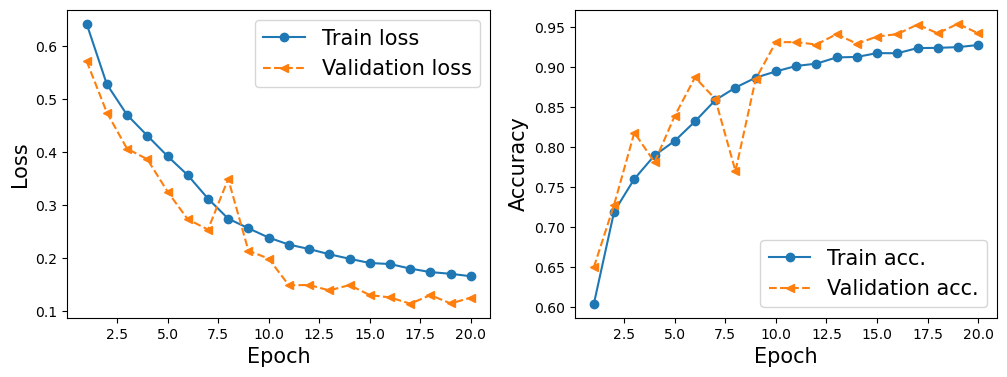

In [15]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

# plt.savefig('images/15_18.png', dpi=300)
plt.show()

In [16]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 93.86%


In [17]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 6s 12ms/step - loss: 0.1648 - accuracy: 0.9301 - val_loss: 0.1060 - val_accuracy: 0.9620
Epoch 22/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1578 - accuracy: 0.9309 - val_loss: 0.1344 - val_accuracy: 0.9340
Epoch 23/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1573 - accuracy: 0.9322 - val_loss: 0.1058 - val_accuracy: 0.9600
Epoch 24/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1555 - accuracy: 0.9324 - val_loss: 0.1259 - val_accuracy: 0.9380
Epoch 25/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1484 - accuracy: 0.9374 - val_loss: 0.1170 - val_accuracy: 0.9510
Epoch 26/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1485 - accuracy: 0.9363 - val_loss: 0.1023 - val_accuracy: 0.9630
Epoch 27/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1506 - accuracy: 0.9356 - val_loss: 0.1057 - val_accuracy:

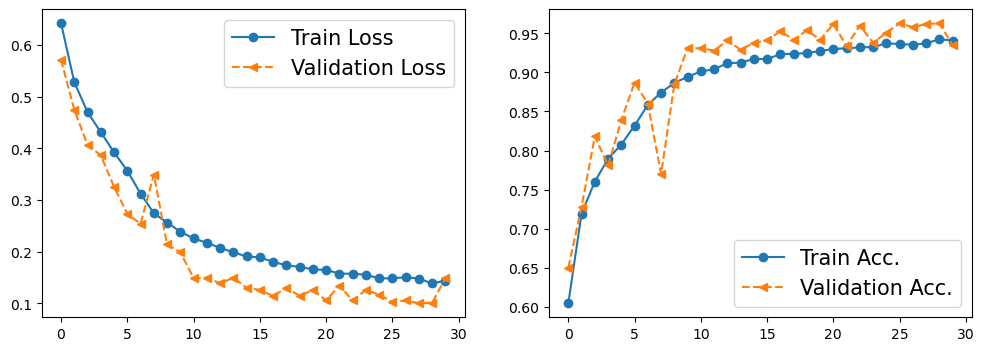

In [18]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'], 
        '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'],
        '--<', label='Validation Loss')
ax.legend(fontsize=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'], 
        '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'], 
        '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [19]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 93.75%


1/1 [==============================] - 1s 848ms/step


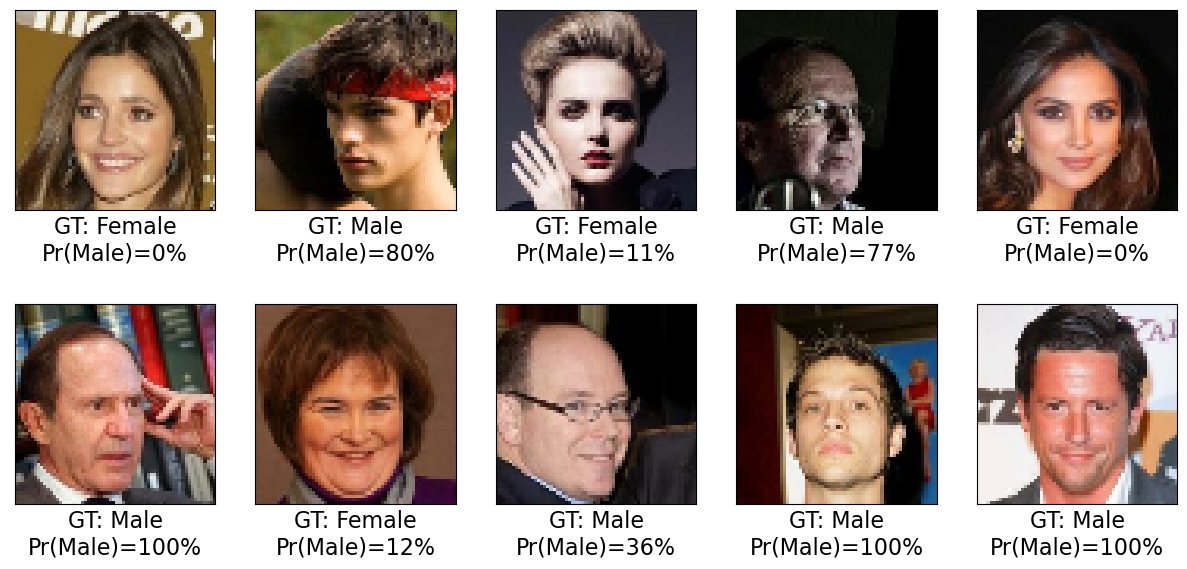

In [20]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
# plt.savefig('images/15_19.png', dpi=300)
plt.show()